In [24]:
%pip install -qqqU langchain pypdf boto3 tiktoken matplotlib umap-learn

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
model_name = "llama3:8b"
embedding_dim = 3072

In [ ]:
from langchain.document_loaders.pdf import PyPDFDirectoryLoader

def load_documents():
    document_loader = PyPDFDirectoryLoader("docs")
    return document_loader.load()


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema.document import Document

def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False
    )

    return text_splitter.split_documents(documents)

In [ ]:
documents = load_documents()
documents = split_documents(documents)
texts = [doc.page_content for doc in documents]

In [ ]:
import tiktoken

def num_tokens_from_string(string: str):
    enconding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(enconding.encode(string))
    return num_tokens

In [ ]:
counts = [num_tokens_from_string(text) for text in texts]

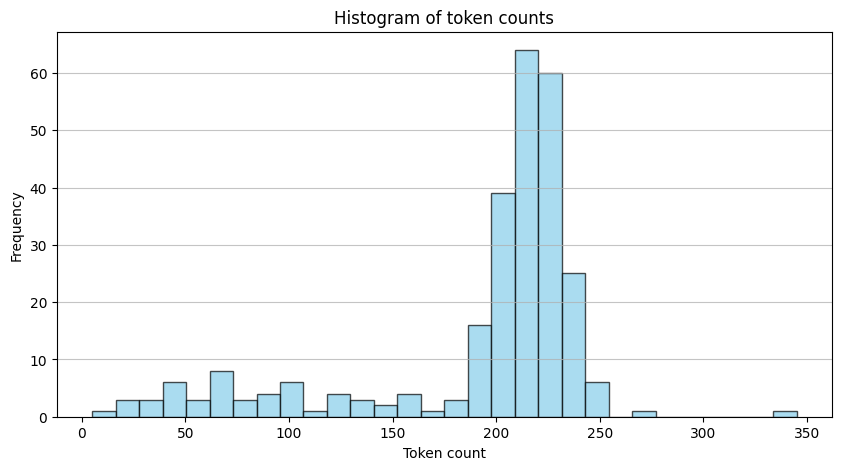

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(counts, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Histogram of token counts")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()


In [ ]:
d_sorted = sorted(documents, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

concatenated_content = "\n\n\n --- \n\n\n".join([doc.page_content for doc in d_reversed])

print(
    "Num tokens in all context:",
    num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 51965


In [ ]:
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_community.llms.ollama import Ollama

embedding_model = OllamaEmbeddings(model=model_name)
model = Ollama(model=model_name, temperature=0.1)

In [ ]:
global_embeddings = [embedding_model.embed_query(text) for text in texts]

In [ ]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)
global_embeddings_reduced[0]

array([-2.4663532,  2.994938 ], dtype=float32)

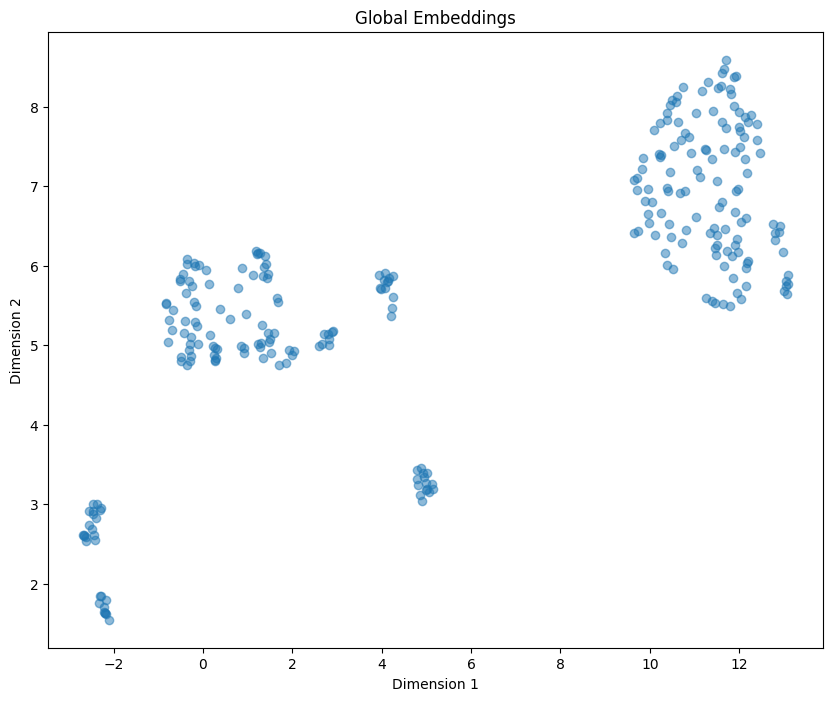

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

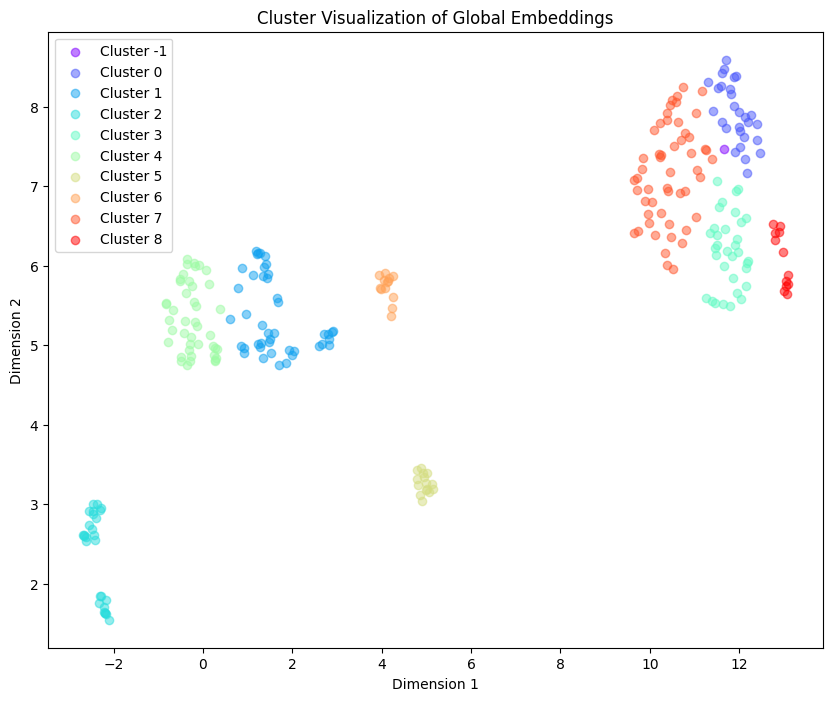

In [ ]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [ ]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
print(df.head(3))

                                                Text               Embedding  \
0  MINISTÉRIO DA EDUCAÇÃO  \nUNIVERSIDADE FEDERAL...  [-2.4663532, 2.994938]   
1  princípio de indissociabilidade entre ensino, ...   [11.296999, 8.307785]   
2  Federal do Rio Grande do Norte - UFRN.  \n \nP...  [4.0735846, 5.7153835]   

   Cluster  
0        2  
1        0  
2        6  


In [ ]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

In [ ]:
clustered_texts = format_cluster_texts(df)
clustered_texts

{2: 'MINISTÉRIO DA EDUCAÇÃO  \nUNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE  \n                  \n       \n \n  \nRESOLUÇÃO Nº 016/2023 -CONSEPE, de 04 de julho de 2023.  \n \n \nAtualiza o Regulamento dos Cursos de Graduação da \nUniversidade Federal do Rio Grande do Norte - UFRN.  \n \n \nO VICE -REITOR DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO NORTE faz saber que o \nConselho de Ensino, Pesquisa e Extensão, no uso das atribuições que lhe confere o art. 17, Inciso III, do \nEstatuto da UFRN,   \n \nCONSIDERANDO o art. 207 da Constituição Federal ao d eterminar que as universidades gozam \nde autonomia didático -científica, administrativa e de gestão financeira e patrimonial, e obedecerão ao \nprincípio de indissociabilidade entre ensino, pesquisa e extensão; --- Parágrafo único. O colegiado do curso, o conselho de centro ou da unidade acadêmica \nespe cializada, a PROGRAD e a Câmara de Graduação devem se pronunciar nos processos de criação e \nextinção de habilitação ou ênfase ou a al

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """Você é um assistente que cria um resumo detalhado do texto de entrada fornecido.
Texto:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [ ]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

In [ ]:
summaries

{2: '**Resumo do Capítulo VI da Transferência de Polo**\n\nA transferência de polo é uma opção exclusiva para estudantes de curso na modalidade à distância, que consiste em desvincular o estudante de seu polo atual e vinculá-lo a outro polo para realizar as atividades presenciais do mesmo curso. A transferência de polo é concedida mediante solicitação do estudante e depende da aprovação pela UFRN.\n\n**Resumo do Capítulo VII da Inclusão e Acessibilidade**\n\nA Secretaria de Inclusão e Acessibilidade (SIA) é responsável por realizar avaliações educacionais dos estudantes que solicitam apoio, emitir pareceres educacionais com orientações acerca das necessidades educacionais específicas dos estudantes e desenvolver processos de avaliação do rendimento acadêmico.\n\n**Resumo do Capítulo VIII dos Documentos Expedidos**\n\nOs documentos oficiais expedidos pela UFRN concernentes ao ensino de graduação são o diploma de conclusão de curso, certificado de conclusão de curso e históricos escolare

In [25]:
embedded_summaries = [embedding_model.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [ ]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [ ]:
clustered_summaries

In [ ]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [ ]:
final_summaries

In [ ]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [ ]:
from langchain_community.vectorstores import Chroma

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=combined_texts, embedding=embedding_model)

In [ ]:
def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.get_relevant_documents(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("Qual os requisitos de turma especifica?", 10000, 4)

In [ ]:
final_number

In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

In [ ]:
from langchain_core.runnables import RunnablePassthrough

template = """
Responda a pergunta baseada no contexto fornecido:
{context}

Responda a pergunta:
Questão: {question}
"""
prompt = ChatPromptTemplate.from_template(template)


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
rag_chain.invoke("Who is the owner of the restaurant")